# Relational Deep Reinforcement Learning

**Plan:**
1. Architecture
2. Agent
3. Environment
4. Training cycle

## Relational architecture

**Input: (b,n,n,1)** = (batch length, linear size, linear size, greyscale)

**Extract entities: (b,n,n,1) -> (b, m, m, 2k)** 
* embedding layer: vocab_size = MAX_PIXELS+1, embedding_dim = n_dim
* convolutional_layer1(kernel_size = (2,2), input_filters = n_dim, output_filters = k, stride = 1, pad = (1,1))
* convolutional_layer2(kernel_size = (2,2), input_filters = k, output_filters = 2k, stride = 1, pad = (1,1))

**Relational block: (b, m, m, 2k) -> (b,d_m)**
* Positional Encoding: (b, m, m, 2k) -> (b, m^2, d_m)
* N Multi-Headed Attention blocks: (b, m^2, d_m) -> (b, m^2, d_m)

**Feature-wise max pooling: (b, m^2, d_m) -> (b, d_m)**

**Multi-Layer Perceptron: (b, d_m) -> (b, d_m)**
* 4 fully connected layers (d_m,d_m) with ReLUs (TODO: add skip-connections)

**Actor output: (b,d_m) -> (b,a)** [a = number of possible actions]
* Single linear layer with softmax at the end

**Critic output: (b,d_m) -> (b,1)** 
* Single linear layer without activation function

## Control architecture

**Input: (b,n,n,1)** = (batch length, linear size, linear size, greyscale)

**Extract entities: (b,n,n,1) -> (b, m, m, 2k)** 
* embedding layer: vocab_size = MAX_PIXELS+1, embedding_dim = n_dim
* convolutional_layer1(kernel_size = (2,2), input_filters = n_dim, output_filters = k, stride = 1, pad = (1,1))
* convolutional_layer2(kernel_size = (2,2), input_filters = k, output_filters = 2k, stride = 1, pad = (1,1))

**1D Convolutional block: (b, m, m, 2k) -> (b, m^2, d_m)**
* Positional Encoding: (b, m, m, 2k) -> (b, m^2, d_m)
* 2 1D convolutional blocks with ReLUs: (b, m^2, d_m) -> (b, m^2, d_m) - pixel-wise

**Feature-wise max pooling: (b, m^2, d_m) -> (b, d_m)**

**Multi-Layer Perceptron: (b, d_m) -> (b, d_m)**
* 4 fully connected layers (d_m,d_m) with ReLUs - feature-wise
* (TODO: add skip-connections)

**Actor output: (b,d_m) -> (b,a)** [a = number of possible actions]
* Single linear layer with softmax at the end

**Critic output: (b,d_m) -> (b,1)** 
* Single linear layer without activation function

In [1]:
import numpy as np
import torch 

import torch.nn as nn
import torch.nn.functional as F

In [2]:
from RelationalModule import RelationalNetworks as rnet
from RelationalModule import ControlNetworks as cnet

In [3]:
from importlib import reload
reload(rnet)
reload(cnet)

<module 'RelationalModule.ControlNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/ControlNetworks.py'>

# Sample image from the game

In [4]:
import sys
sys.path.insert(0, "pycolab/pycolab/examples/research/box_world")
import box_world as bw

In [5]:
def get_state(observation, mask=True):
    #print("Keys: ", observation.layers.keys())
    board = observation.board#.astype('float')
    
    if mask:
        walls = observation.layers['#'].astype(int)
        #print("walls: ", walls)
        background = observation.layers[' '].astype(int)
        #print("background: ", background)
        ambient = walls + background
        #print("ambient: ", ambient)
        board[ambient.astype(bool)] = 0
        #print("board (masked): ", board)
    grid_size = board.shape[0]
    board = board.reshape(1, grid_size, grid_size)
    return board #/MAX_PIXEL

In [6]:
def print_key_values(observation):
    layers = observation.layers
    board = observation.board
    print("\nKeys: ", layers.keys())
    for k in layers.keys():
        values = board[layers[k]]
        if k == ' ':
            print("background ", np.max(values))
        elif k == '#':
            print("wall ", np.max(values))
        elif k == '.':
            print("agent ",  np.max(values))
        else:
            print(k, np.max(values))

In [7]:
def get_init_state():
    GRID_SIZE = 12
    game_params = dict(grid_size=GRID_SIZE,
                    solution_length=[2], # number of boxes to be opened to get the gem
                    num_forward = [1], # number of distractors
                    num_backward=[0], # just set to 0 for now
                    branch_length=1, # length of forward distractors
                    max_num_steps = 50
                   )
    game = bw.make_game(**game_params)



    observation, _, _ = game.its_showtime()
    print_key_values(observation)
    state = get_state(observation)
    state = torch.from_numpy(state.astype(int))
    return state

In [8]:
states = [get_init_state() for _ in range(5)]


Keys:  dict_keys(['#', 'G', '*', 'm', 'L', 'g', 'l', '.', ' '])
wall  35
G 71
* 42
m 109
L 76
g 103
l 108
agent  46
background  32

Keys:  dict_keys(['#', 'r', 'o', '*', 'p', 'P', '.', ' ', 'R'])
wall  35
r 114
o 111
* 42
p 112
P 80
agent  46
background  32
R 82

Keys:  dict_keys(['#', 'r', 'o', '*', 'm', 'O', '.', ' ', 'R'])
wall  35
r 114
o 111
* 42
m 109
O 79
agent  46
background  32
R 82

Keys:  dict_keys(['#', 'G', '*', 'g', 'f', 'l', 'F', '.', ' '])
wall  35
G 71
* 42
g 103
f 102
l 108
F 70
agent  46
background  32

Keys:  dict_keys(['#', 's', 'G', '*', 'p', 'P', 'g', '.', ' '])
wall  35
s 115
G 71
* 42
p 112
P 80
g 103
agent  46
background  32


/home/nicola/anaconda3/envs/torch/lib/python3.7/site-packages/pycolab/ascii_art.py:318: FutureWarning: arrays to stack must be passed as a "sequence" type such as list or tuple. Support for non-sequence iterables such as generators is deprecated as of NumPy 1.16 and will raise an error in the future.
  art = np.vstack(np.fromstring(line, dtype=np.uint8) for line in art)


So we can see that actually the agent, the wall, the background and the gem have always the same value along episodes. Also same key-box couples have the same pair color, so once experienced a certain opening, that opening can be memorized and used in the future (otherwise the agent should rely on pure chance and trying to open every box every time).

A simpler setup would be that of masking to 0 all walls and background, at least to see if there is anything about them that is impeding the learning process.

# Embedding layer

In [9]:
import matplotlib.pyplot as plt

In [10]:
vocab_size = 256
n_dim = 3
embed = nn.Embedding(vocab_size, n_dim, padding_idx=0)

In [11]:
zeros = torch.ones((10,10), dtype=int)
y_zeros = embed(zeros)
print("y_zeros.shape: ", y_zeros.shape)
print(y_zeros[:,:,0])
print(y_zeros[:,:,1])
print(y_zeros[:,:,2])

y_zeros.shape:  torch.Size([10, 10, 3])
tensor([[-0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961,
         -0.4961, -0.4961],
        [-0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961,
         -0.4961, -0.4961],
        [-0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961,
         -0.4961, -0.4961],
        [-0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961,
         -0.4961, -0.4961],
        [-0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961,
         -0.4961, -0.4961],
        [-0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961,
         -0.4961, -0.4961],
        [-0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961,
         -0.4961, -0.4961],
        [-0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961,
         -0.4961, -0.4961],
        [-0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961, -0.4961,
       

Same integer values get mapped to same vectors, as it should be. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


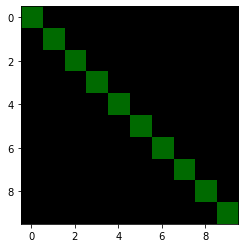

In [12]:
eye = torch.eye(10, dtype=int)
y_eye = embed(eye).detach()
plt.imshow(y_eye.numpy())

Again the embedding works, since each integer value is associated to a particular vector (in this case 3D vector, that can be represented as RGB color once clipped).

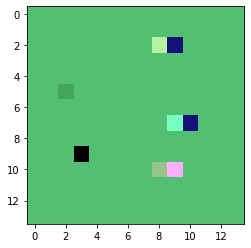

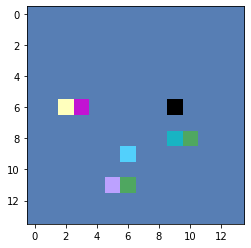

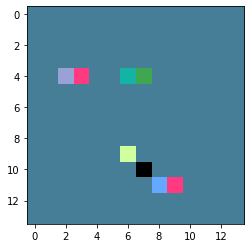

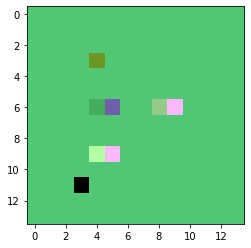

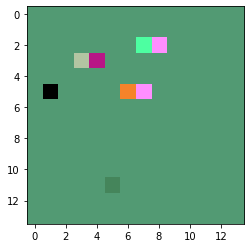

In [13]:
for state in states:
    x = state
    if len(x.shape) <= 3:
        x = x.unsqueeze(0)
    #print("x.shape (before embed): ", x.shape)
    x = embed(x)
    #print("x.shape (after embed): ", x.shape)
    #print("x.sum in slices: ", sum_slices(x,(0,1)))
    x = x.transpose(-1,-3)
    #print("x.shape: ", x.shape)
    x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1]).squeeze()
    #print("x.shape: ", x.shape)
    ### This part is just for correct visualization after embedding ###
    x = x.transpose(-1,0)
    x = x.transpose(1,0)
    #print("x.shape: ", x.shape)
    x = x.detach().numpy()
    M = x.max(axis=(0,1))
    m= x.min(axis=(0,1))
    #print("M: ", M.shape )
    #print("m: ", m.shape)
    x = (x - m)/(M-m)
    plt.imshow(x)
    plt.show()

Given this simple rendering (after embedding) from naked eye we can only see that:
1. keys have different colors from the boxes they should open
2. distractors are identical to the right boxes

Then we also have to notice that in this representation colors are biased because I had to normalize in [0,1] the "RGB" channels given by the embedding.

# Convolution layers

In [14]:
use_state = True

In [15]:
k_in = 1
k_out = 24
kernel_size = 2
stride = 1
padding = 0

layers = []
layers.append(nn.Conv2d(n_dim*k_in, k_out//2, kernel_size, stride, padding))
layers.append(nn.ReLU())
layers.append(nn.Conv2d(k_out//2, k_out, kernel_size, stride, padding))
#layers.append(nn.ReLU())
net = nn.Sequential(*layers)

In [16]:
def sum_slices(x, axes):
    return x.squeeze().sum(axis=axes).detach()

In [17]:
if use_state:
    x = states[0]
else:
    x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
y = net(x)
print("y.shape: ", y.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([ 1.7472, -4.2571,  2.8076])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
y.shape:  torch.Size([1, 24, 12, 12])


In [18]:
y = y.squeeze().detach()
print(sum_slices(y,(1,2)))
print("y[0,:,:]: ", y[0,:,:])

tensor([  6.6749,  14.0352,  16.6094,  14.2386, -31.9373,   2.2518, -12.9930,
         -0.3285,   7.8860,  -4.1798,  16.8642, -14.3151,   7.9392,   1.9712,
         27.7309,  24.8676,  16.3338, -15.4950,  30.8715,  -1.9885,   4.9507,
        -11.7801,   1.6527,  -4.3511])
y[0,:,:]:  tensor([[ 0.0561,  0.0561,  0.0561,  0.0561,  0.0561,  0.0561,  0.0660, -0.0124,
          0.1527,  0.0540,  0.0561,  0.0561],
        [ 0.0561,  0.0561,  0.0561,  0.0561,  0.0561,  0.0561,  0.0913, -0.1649,
          0.0755,  0.0050,  0.0561,  0.0561],
        [ 0.0561,  0.0561,  0.0561,  0.0561,  0.0561,  0.0561,  0.0047,  0.0176,
          0.0769,  0.0260,  0.0561,  0.0561],
        [ 0.0343,  0.0659,  0.0572,  0.0561,  0.0561,  0.0561,  0.0561,  0.0561,
          0.0561,  0.0561,  0.0561,  0.0561],
        [ 0.0114,  0.0756,  0.0666,  0.0561,  0.0561,  0.0561,  0.0561,  0.0561,
          0.0561,  0.0561,  0.0561,  0.0561],
        [ 0.0750,  0.0994,  0.0270,  0.0561,  0.0561,  0.0561,  0.0561,  0.0821,


So basically each layer is uniform thanks to the input and how convolution works (each slice is the result of the convolution from the same kernel of the same input). All the zeros that can be seen are due to the ReLU activations.

# Positional Encoding

In [19]:
def add_encoding2D(x):
    x_ax = x.shape[-2]
    y_ax = x.shape[-1]

    x_lin = torch.linspace(-1,1,x_ax)
    xx = x_lin.repeat(x.shape[0],y_ax,1).view(-1, 1, y_ax, x_ax).transpose(3,2)

    y_lin = torch.linspace(-1,1,y_ax).view(-1,1)
    yy = y_lin.repeat(x.shape[0],1,x_ax).view(-1, 1, y_ax, x_ax).transpose(3,2)

    x = torch.cat((x,xx,yy), axis=1)
    return x

In [20]:
if use_state:
    x = states[0]
else:
    x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
y = net(x)
print("y.shape: ", y.shape)
y_enc = add_encoding2D(y)
print("y_enc.shape: ", y_enc.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([ 1.7472, -4.2571,  2.8076])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
y.shape:  torch.Size([1, 24, 12, 12])
y_enc.shape:  torch.Size([1, 26, 12, 12])


Let's verify that the last 2 layers have a positional encoding:

y_tmp.shape:  torch.Size([26, 12, 12])


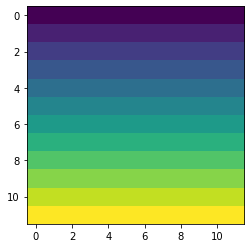

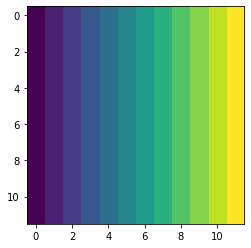

In [21]:
y_tmp = y_enc.squeeze().detach()
print("y_tmp.shape: ", y_tmp.shape)
plt.imshow(y_tmp[-2])
plt.show()
plt.imshow(y_tmp[-1])
plt.show()

A different approach would be to sum these two layers pixel-wise to all other features. Probably it would amplify the importance of the position, at the risk that if the magnitude is too high we would lose data.

Also more complicated encodings are possible; this one is the one I think they used in the paper.

# Projection from 26 to n_features (default 256)

In [22]:
n_features = 256
projection = nn.Linear(k_out + 2, n_features)

In [23]:
if use_state:
    x = states[0]
else:
    x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([ 1.7472, -4.2571,  2.8076])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
x.shape:  torch.Size([1, 24, 12, 12])
x.shape:  torch.Size([1, 26, 12, 12])
x.shape:  torch.Size([1, 26, 144])
x.shape:  torch.Size([1, 144, 26])
x.shape:  torch.Size([1, 144, 256])
x.shape:  torch.Size([144, 1, 256])


Here everything seems clean. Let's see if there is some trace of the positional encoding left. Ideally thanks to the projection now each feature potentially has a positional encoding.

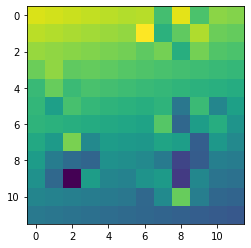

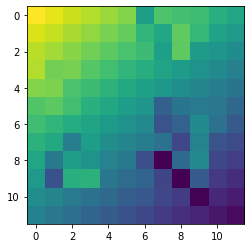

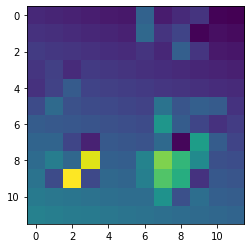

In [24]:
x_tmp = x.squeeze().detach().view(12,12,256)
plt.imshow(x_tmp[:,:,0])
plt.show()
plt.imshow(x_tmp[:,:,128])
plt.show()
plt.imshow(x_tmp[:,:,-2])
plt.show()

Again everything seems fine.

# Relational Block 
Implements the relational block, composed by a Multi-Headed Dot-Product Attention layer followed by a Position-wise Feed-Forward layer. I implement here the former one, whereas I just import the latter from the module, since it's very basic.

In [25]:
hidden_dim = 64
dropout = 0
n_heads = 4

norm = nn.LayerNorm(n_features)
drop = nn.Dropout(dropout) # disabled
attn = nn.MultiheadAttention(n_features, n_heads, dropout)
ff = rnet.PositionwiseFeedForward(n_features, hidden_dim, dropout)

In [26]:
if use_state:
    x = states[0]
else:
    x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x_tmp = x # save it for plotting

# From here it has always the same shape
attn_output, attn_output_weights =  attn(x,x,x, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
out = drop(norm(x_ff))
print("out.shape: ", out.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([ 1.7472, -4.2571,  2.8076])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
x.shape:  torch.Size([1, 24, 12, 12])
x.shape:  torch.Size([1, 26, 12, 12])
x.shape:  torch.Size([1, 26, 144])
x.shape:  torch.Size([1, 144, 26])
x.shape:  torch.Size([1, 144, 256])
x.shape:  torch.Size([144, 1, 256])
attn_output.shape:  torch.Size([144, 1, 256])
x_add.shape:  torch.Size([144, 1, 256])
x_norm.shape:  torch.Size([144, 1, 256])
x_ff.shape:  torch.Size([144, 1, 256])
out.shape:  torch.Size([144, 1, 256])


In [27]:
def plot_layer(x, layer=0):
    x = x.squeeze().detach()[:,layer]
    plt.imshow(x.view(12,12))
    plt.show()

Input


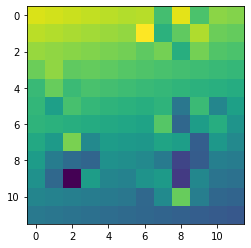

Attention output


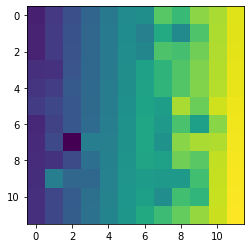

Input + attention


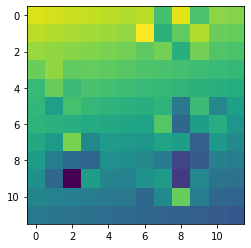

After LayerNorm


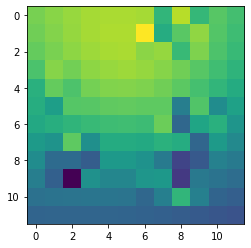

After position-wise FF


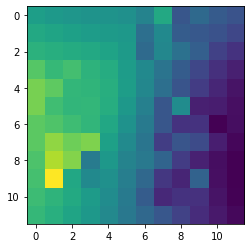

After LayerNorm


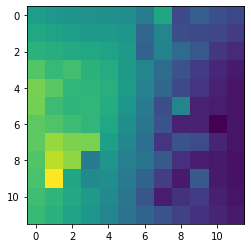

In [28]:
print("Input")
plot_layer(x_tmp)
print("Attention output")
plot_layer(attn_output)
print("Input + attention")
plot_layer(x_add)
print("After LayerNorm")
plot_layer(x_norm)
print("After position-wise FF")
plot_layer(x_ff)
print("After LayerNorm")
plot_layer(out)

Here we didn't see anything suspicious, with the attention layer not doing much and the only real change happening during the positionwise feed forward, in which we make a convolution of the 256 features to obtain new ones, so of course after that we are looking at a different feature plane.

To see if the attention layer is working correctly, we can play with the pixel and batch asix and see if the result is affected by those changes. Since the attention mechanism works taking into account relations between pixels, masking some of them should change the output for the others. Instead the batch dimension shouldn't intefrere with the result.

In [29]:
# Check if batch size changes the output
if use_state:
    x = states[0]
else:
    x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x_tmp2 = torch.cat((x,x), axis=1)
attn_output, attn_output_weights =  attn(x_tmp2,x_tmp2,x_tmp2, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
out2 = drop(norm(x_ff))
out3 = out2[:,1,:].unsqueeze(1)
out2 = out2[:,0,:].unsqueeze(1)

print("out2.shape: ", out2.shape)
print("out2: ", out2)
print("out: ", out)
print("Element sum of the difference 2-3: ", torch.sum(out2- out3).item())
print("Element sum of the difference 2-0: ", torch.sum(out2- out).item())

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([ 1.7472, -4.2571,  2.8076])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
x.shape:  torch.Size([1, 24, 12, 12])
x.shape:  torch.Size([1, 26, 12, 12])
x.shape:  torch.Size([1, 26, 144])
x.shape:  torch.Size([1, 144, 26])
x.shape:  torch.Size([1, 144, 256])
x.shape:  torch.Size([144, 1, 256])
attn_output.shape:  torch.Size([144, 2, 256])
x_add.shape:  torch.Size([144, 2, 256])
x_norm.shape:  torch.Size([144, 2, 256])
x_ff.shape:  torch.Size([144, 2, 256])
out2.shape:  torch.Size([144, 1, 256])
out2:  tensor([[[ 4.7980e-02, -1.7451e+00, -5.5659e-01,  ...,  1.9715e+00,
          -1.3585e+00,  1.7672e+00]],

        [[-3.3928e-04, -1.6837e+00, -4.0887e-01,  ...,  1.9472e+00,
          -1.4058e+00,  1.7389e+00]],

        [[-2.9457e-02, -1.6042e+00, -2.0486e-01,  ...,  1.9267e+00,
          -1.4431e+00,  1.6865e+00]],

        ...,

out2 = out3 means that the batch dimension correctly hasn't changed the result, because the same input has been concatenated along that axes and the same two outputs have been obtained on the other end. out2 = out shows that different samples are handled independently, as it should happen.

In [30]:
# Check if pixel sequence changes the output
if use_state:
    x = states[0]
else:
    x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)
x_tmp1 = x
x_tmp1[100:] = 0. # mask last 44 positions
attn_output, attn_output_weights =  attn(x_tmp1,x_tmp1,x_tmp1, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
out1 = drop(norm(x_ff))

print("out1: ", out1)
print("out: ", out)
print("Element sum of the difference: ", torch.sum(out1 - out).item())

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([ 1.7472, -4.2571,  2.8076])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
x.shape:  torch.Size([1, 24, 12, 12])
x.shape:  torch.Size([1, 26, 12, 12])
x.shape:  torch.Size([1, 26, 144])
x.shape:  torch.Size([1, 144, 26])
x.shape:  torch.Size([1, 144, 256])
x.shape:  torch.Size([144, 1, 256])
attn_output.shape:  torch.Size([144, 1, 256])
x_add.shape:  torch.Size([144, 1, 256])
x_norm.shape:  torch.Size([144, 1, 256])
x_ff.shape:  torch.Size([144, 1, 256])
out1:  tensor([[[ 0.0226, -1.7670, -0.4932,  ...,  2.1063, -1.3240,  1.7334]],

        [[-0.0264, -1.7003, -0.3267,  ...,  2.0839, -1.3670,  1.7042]],

        [[-0.0741, -1.6122, -0.1323,  ...,  2.0432, -1.4113,  1.6621]],

        ...,

        [[ 0.6614, -1.2007, -0.5566,  ...,  0.0562, -1.3143, -0.0453]],

        [[ 0.6614, -1.2007, -0.5566,  ...,  0.0562, -1.3143, -0.04

As can be seen, the new output has changed, as it should.

**LayerNorm formula**
$$y = \frac{x - \mathrm{E}[x]}{ \sqrt{\mathrm{Var}[x] + \epsilon}} * \gamma + \beta$$

In [31]:
# What LayerNorm does

E = x_add[0,0,:].mean()
print("E: ", E)
V = x_add[0,0,:].var()
print("V: ", V)
y = (x_add[0,0,:]-E)/torch.sqrt(V+1e-5)
print("LayerNorm by hand: \n", y)
print("LayerNorm: \n", x_norm[0,0,:])

E:  tensor(0.0004, grad_fn=<MeanBackward0>)
V:  tensor(0.0381, grad_fn=<VarBackward0>)
LayerNorm by hand: 
 tensor([ 1.9893e+00, -8.5217e-01, -5.7632e-01,  1.2441e+00, -1.5713e+00,
        -9.4162e-01,  4.3444e-02,  4.2147e-01, -4.3648e-01, -5.5045e-02,
        -1.0682e+00,  1.5575e+00, -2.9869e-01,  2.2145e+00, -4.9988e-01,
         6.5057e-01, -8.4595e-01,  1.3178e+00,  1.6454e+00,  2.6232e-01,
        -2.1929e-01,  3.1652e-03,  1.1182e+00,  3.6727e-02, -4.0001e-01,
        -1.0066e+00,  9.7930e-01, -1.5724e-01,  1.0837e+00, -1.4882e+00,
         8.3015e-01, -5.6747e-01,  9.7446e-01,  8.8969e-01, -1.3483e+00,
        -1.0603e+00, -1.3534e+00,  2.5337e-01,  6.4825e-01, -8.7351e-01,
        -1.3084e-01, -1.3249e-01, -4.4854e-01,  1.9216e+00, -7.4055e-01,
        -3.1887e-01,  2.4704e+00,  1.1530e+00, -1.5721e-01,  7.2516e-01,
         1.0979e-01, -1.0304e+00,  2.8009e-01,  2.5901e-01, -6.1072e-02,
         3.7586e-01,  2.4138e-01,  1.5800e+00, -2.8823e-01, -1.0391e+00,
        -4.6264e

# Featurewise MaxPooling

For each feature, take the maximum value among the pixels.

In [32]:
x = torch.zeros((1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x_tmp = x # save it for plotting

# From here it has always the same shape
attn_output, attn_output_weights =  attn(x,x,x, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
x = drop(norm(x_ff))
print("x.shape: ", x.shape)
# Max pooling feature-wise
x, _ = torch.max(x, axis=0)
print("x.shape: ", x.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([0., 0., 0.])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
x.shape:  torch.Size([1, 24, 12, 12])
x.shape:  torch.Size([1, 26, 12, 12])
x.shape:  torch.Size([1, 26, 144])
x.shape:  torch.Size([1, 144, 26])
x.shape:  torch.Size([1, 144, 256])
x.shape:  torch.Size([144, 1, 256])
attn_output.shape:  torch.Size([144, 1, 256])
x_add.shape:  torch.Size([144, 1, 256])
x_norm.shape:  torch.Size([144, 1, 256])
x_ff.shape:  torch.Size([144, 1, 256])
x.shape:  torch.Size([144, 1, 256])
x.shape:  torch.Size([1, 256])


Nothing much to control here.

# Alternative to max pooling - Linear projection

In [33]:
reload(rnet)

<module 'RelationalModule.RelationalNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/RelationalNetworks.py'>

In [34]:
linear_proj = nn.Linear(144,1) # needs to know how many pixels there are

In [35]:
x = torch.zeros((1,1,14,14), dtype=int) # this is the structure of the state retrieved by the game
if len(x.shape) <= 3:
    x = x.unsqueeze(0)
print("x.shape (before embed): ", x.shape)
x = embed(x)
print("x.shape (after embed): ", x.shape)
print("x.sum in slices: ", sum_slices(x,(0,1)))
x = x.transpose(-1,-3)
print("x.shape: ", x.shape)
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
print("x.shape: ", x.shape)
x = net(x)
print("x.shape: ", x.shape)
x= add_encoding2D(x)
print("x.shape: ", x.shape)
x = x.view(x.shape[0], x.shape[1],-1)
print("x.shape: ", x.shape)
x = x.transpose(2,1)
print("x.shape: ", x.shape)
x = projection(x)
print("x.shape: ", x.shape)
x = x.transpose(1,0)
print("x.shape: ", x.shape)

x_tmp = x # save it for plotting

# From here it has always the same shape
attn_output, attn_output_weights =  attn(x,x,x, key_padding_mask=None) # MHA step
print("attn_output.shape: ", attn_output.shape)
x_add = attn_output + x
print("x_add.shape: ", x_add.shape)
x_norm = drop(norm(x_add))
print("x_norm.shape: ", x_norm.shape)
x_ff = ff(x_norm)
print("x_ff.shape: ", x_ff.shape)
x = drop(norm(x_ff))
print("x.shape: ", x.shape)

# Feature-wise projection
x = x.transpose(-1,0)
print("x.shape (before linear): ", x.shape)
shape = x.shape
x = linear_proj(x).reshape(shape[0],shape[1])
print("x.shape: ", x.shape)
x = x.transpose(-1,0)
print("x.shape: ", x.shape)

x.shape (before embed):  torch.Size([1, 1, 14, 14])
x.shape (after embed):  torch.Size([1, 1, 14, 14, 3])
x.sum in slices:  tensor([0., 0., 0.])
x.shape:  torch.Size([1, 1, 3, 14, 14])
x.shape:  torch.Size([1, 3, 14, 14])
x.shape:  torch.Size([1, 24, 12, 12])
x.shape:  torch.Size([1, 26, 12, 12])
x.shape:  torch.Size([1, 26, 144])
x.shape:  torch.Size([1, 144, 26])
x.shape:  torch.Size([1, 144, 256])
x.shape:  torch.Size([144, 1, 256])
attn_output.shape:  torch.Size([144, 1, 256])
x_add.shape:  torch.Size([144, 1, 256])
x_norm.shape:  torch.Size([144, 1, 256])
x_ff.shape:  torch.Size([144, 1, 256])
x.shape:  torch.Size([144, 1, 256])
x.shape (before linear):  torch.Size([256, 1, 144])
x.shape:  torch.Size([256, 1])
x.shape:  torch.Size([1, 256])


## Residual Layer

Here the original paper uses just a Multi-Layer Perceptron, but I thought it would be nice to have sone skip connections in order to make the architecture more flexible.

In [36]:
reload(rnet)

<module 'RelationalModule.RelationalNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/RelationalNetworks.py'>

In [37]:
n_hiddens = 256 
residual_layer = rnet.ResidualLayer(n_features, n_hiddens)

In [38]:
residual_layer(x) - x # residual after ReLU

tensor([[ 4.8460e-01, -2.1203e-01,  3.6038e-02, -2.4075e-01, -6.1428e-02,
         -4.3773e-01,  1.7896e-01,  9.3542e-02,  5.6518e-02, -1.3073e-01,
          4.0516e-01,  4.1768e-02,  4.4066e-01,  2.7531e-01, -3.3811e-01,
          6.3777e-02, -3.4310e-01, -2.5782e-01,  1.6597e-01,  1.1784e-01,
          2.0842e-01,  6.2776e-01,  4.2080e-01,  3.6995e-01,  2.3166e-01,
          1.6686e-02, -3.7494e-01, -1.8448e-01, -1.3369e-01,  1.6521e-01,
          6.6117e-02,  1.8935e-01, -9.1438e-02, -1.4511e-01,  2.7670e-01,
         -5.0264e-01, -2.6626e-01, -1.4028e-01,  1.4984e-01,  8.0465e-02,
          1.7277e-02,  7.0212e-02,  1.3874e-01,  5.2757e-01, -4.6146e-01,
          1.2035e-01,  1.4908e-01,  1.7456e-01,  2.8285e-01, -1.0268e-01,
          8.5883e-03, -4.1309e-01, -2.7675e-02,  3.2127e-01, -2.7828e-02,
         -3.0054e-01, -9.5205e-02,  8.7826e-03, -2.5902e-01,  3.1412e-01,
         -4.2685e-01,  7.3843e-02, -2.1069e-01, -1.2601e-01,  2.3054e-01,
          3.9778e-02, -3.0043e-01, -4.

# Full architecture

In [39]:
reload(rnet)
reload(cnet)

<module 'RelationalModule.ControlNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/ControlNetworks.py'>

In [40]:
box_net = rnet.BoxWorldNet(in_channels=1, n_kernels=24, vocab_size=117, n_dim=3,
                              n_features=256, n_attn_modules=2, n_linears=4)

In [41]:
box_net_v1 = rnet.BoxWorldNet(in_channels=1, n_kernels=24, vocab_size=117, n_dim=3,
                              n_features=256, n_attn_modules=2, n_linears=4, max_pool=False,
                              linear_size=14)

In [42]:
control_net = cnet.ControlNet(in_channels=1, n_kernels=24, vocab_size=117, n_dim=3,
                              n_features=256, hidden_dim=64, n_control_modules=2, n_linears=4)

In [43]:
x = torch.randint(high=116, size = (1,14,14))

In [44]:
y = box_net_v1(x)
print("y.shape: ", y.shape)
y

y.shape:  torch.Size([1, 256])


tensor([[-0.3471,  0.8706, -0.4643,  1.2401, -1.6211,  0.3449,  0.2921,  1.0621,
         -0.2333,  1.5033,  2.4991, -0.6925,  0.0790, -0.1385,  1.7330,  1.0484,
          1.6266, -0.7349,  0.6350, -0.7732,  1.4494, -0.3380,  0.5469,  0.7647,
         -0.2781, -0.3455,  0.2698,  0.6114,  1.7113, -0.2367,  0.5861, -0.6365,
         -0.0982,  0.9901, -0.8879, -1.5596, -1.2381, -1.7931,  1.5929,  0.8265,
          0.9735, -0.9042, -1.2004,  0.0615, -0.6152,  2.1911, -0.7978,  2.0214,
         -1.0261, -0.2894,  0.5326,  0.2119,  0.3012,  1.8253, -0.3202, -1.0710,
         -0.3215,  0.1950, -0.0233, -0.2272, -0.2524, -0.8804, -0.7720,  0.4124,
         -1.1940,  0.6481, -0.4766,  1.7432,  0.7434, -0.5072,  0.2930, -0.4310,
         -0.2838,  2.2826, -0.8645,  1.0152,  0.0650,  0.6260,  0.8871,  0.0907,
         -0.8889,  1.4125, -0.2689, -0.5767, -0.4513, -0.7602,  0.7972, -1.1460,
          0.5217, -0.5251,  0.4385, -1.9822, -0.7412,  0.9380, -0.5870, -1.2729,
          0.1396,  0.0029, -

In [45]:
y = control_net(x)
print("y.shape: ", y.shape)
y

y.shape:  torch.Size([1, 256])


tensor([[-3.2803e-02,  2.0822e-02,  1.4306e+00,  6.9601e-02, -2.1392e-02,
          9.7195e-02,  4.0695e-01,  8.9766e-02,  3.0813e-01,  2.1562e-02,
         -4.7502e-02,  3.8975e-02,  2.4358e-01, -3.1116e-02,  1.1931e-01,
          1.1460e+00, -7.8290e-02,  1.9484e-01,  2.3399e-01,  4.3689e-01,
         -1.9378e-02,  1.6107e-01,  2.2890e-02,  5.7375e-01, -3.3701e-02,
          5.0325e-01,  9.6816e-01, -7.9721e-02,  4.6646e-01,  3.9455e-01,
          8.0544e-01,  1.2765e-01,  6.1071e-02,  1.4714e+00,  2.5545e+00,
          7.6160e-01,  2.1509e+00, -1.3133e-02,  1.2686e-01,  1.8105e-01,
          5.6487e-01,  1.0540e-01,  9.6941e-01,  5.1679e-01, -1.3569e-02,
          2.2521e-01,  2.4763e-01, -2.8501e-02,  3.7218e-02,  3.0057e-02,
          6.3495e-02,  1.1455e-01,  1.9283e-01,  1.2721e+00,  1.9387e-02,
          3.0650e-02,  1.7011e-01, -6.2881e-02,  1.2170e+00, -4.7739e-02,
          4.3875e-01,  3.6177e-01,  7.1898e-01,  2.0818e-01, -6.9076e-02,
          8.9868e-01,  8.7187e-01,  4.

# Multi-channel embedding layer test

Here I just wanted to see how to embed even images with more than one channel

In [46]:
reload(rnet)

<module 'RelationalModule.RelationalNetworks' from '/home/nicola/Nicola_unipd/MasterThesis/RelationalDeepRL/RelationalModule/RelationalNetworks.py'>

In [47]:
get_entities = rnet.ExtractEntities(k_out = 24, k_in=3, n_dim=3)

In [48]:
embed = nn.Embedding(255,3)

In [49]:
x = torch.randint(high=116, size = (3,14,14))

In [50]:
get_entities(x).shape

torch.Size([1, 24, 12, 12])

In [51]:
x = x.transpose(-1,-2).reshape(x.shape[0],-1,x.shape[-2],x.shape[-1])
x.shape

torch.Size([3, 1, 14, 14])

In [52]:
bw_net = rnet.BoxWorldNet()

In [53]:
bw_net(x).shape

torch.Size([3, 256])